# <font color="blue" ><font size="4">An Analytical Pressure Transient Analysis of the Injection Fall-Off Test using Horner Semilog Plot</font></font>
<font size="2">This script tries to demonstrate injection fall-off test in a geothermal well using analytical method. The data used in here is dummy/synthetic data. The calculation used Horner plot. Some basic assumptions as stated by (Matthews
and Russell, 1967; Earlougher, 1977; Horne, 1995) in (Zarrouk and Mcclean, 2019) to perform the analytical pressure transient analysis
- Homogeneous and isotropic porous medium (uniform permeability in all directions)
- Neglecting gravity effects
- Single phase flow
- Porosity, permeability, viscosity and compressibility are constant and therefore independent of pressure

</font>


### <font size = 2><u>The first step is to import the data</u></font>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the csv file
rawdf = pd.read_csv('0209_falloff_well_D1.csv')

print(rawdf.head(5))

                  Time  Res_Press(bar)  Mass_Flow(t/h)
0  09/02/2025 21:00:00      159.065153              40
1  09/02/2025 21:04:45      159.085343              40
2  09/02/2025 21:09:29      159.141243              40
3  09/02/2025 21:14:14      159.210143              40
4  09/02/2025 21:18:59      159.342443              40


<font size=2>It can be seen that the column name are 'Time', 'Res_Press(bar)', and 'Mass_flow(t/h)'.
By recognizing this, columns are able to be converted and can be transform into arrays.</font>

In [4]:
# Extract each columns from csv into array
time = rawdf['Time']
res_press = np.array(rawdf['Res_Press(bar)'])
flow_th = np.array(rawdf['Mass_Flow(t/h)'])

# Convert the data from barg to bara and pressure, t/h to kg/s
rawdf['Res_Press(bara)'] = res_press+1 #assuming 1 bar for atmosphere pressure
rawdf['Res_Press(Pa)'] = rawdf['Res_Press(bara)']*1e5
rawdf['Flow(kg/s)'] = (flow_th*1000)/3600

<font size=2>Since the data contains of injection period and fall-off period, I want to make the first data set for the injection and second data set for fall off for easier analysis. Therefore, the data is split when the injection becomes 0 t/h</font>

In [5]:
# Find the index where the mass flow is 0
split_index = rawdf[rawdf['Mass_Flow(t/h)'] == 0].index[0]
# Split the dataframe into two datasets
ds1 = rawdf.iloc[:split_index]
ds2 = rawdf.iloc[split_index:]
# Copy the data into injection dataset and fall-off dataset
inj_ds = ds1.copy()
fao_ds = ds2.copy()

<font size=2>
Note that the time column consists of date and time format <i>(mm/dd/yy hh:mm:ss)</i>. Hence, I need to extract the data from the time column, and create a new column of duration (s).
The duration column is the difference of time between the n row and n+1 row. 
For example the 1st column = 2nd row - 1st row; and so on.

This was done so the horner time can be perform, on the other hand this column is the $dt$.

In addition, when spliting the dataframe, the last row of $dt$ in the <i>inj_ds</i> needs an adjustment because the row after that has already separated, therefore we need to substract the first row of <i>fao_ds</i> to last row of <i>inj_ds</i>
</font>

In [6]:
# Convert the time column to datetime format, accessible by pandas
inj_ds['Time'] = pd.to_datetime(inj_ds['Time'])
fao_ds['Time'] = pd.to_datetime(fao_ds['Time'])

# Subtract n row from the n-1 row for duration column
inj_ds['Duration(s)'] = inj_ds['Time'].diff().shift(-1).fillna(pd.Timedelta(seconds=0))
fao_ds['Duration(s)'] = fao_ds['Time'].diff().shift(-1).fillna(pd.Timedelta(seconds=0))

inj_ds['Duration(s)'] = inj_ds['Duration(s)'].dt.total_seconds().astype(float)
fao_ds['Duration(s)'] = fao_ds['Duration(s)'].dt.total_seconds().astype(float)

# Adjust the last row of inj_ds
if not inj_ds.empty and not fao_ds.empty:
    inj_ds.loc[inj_ds.index[-1], 'Duration(s)'] = (fao_ds.loc[fao_ds.index[0], 'Time'] - inj_ds.loc[inj_ds.index[-1], 'Time']).total_seconds()

print(inj_ds.tail(5))
print(fao_ds.tail(5))

                  Time  Res_Press(bar)  Mass_Flow(t/h)  Res_Press(bara)  \
93 2025-09-03 03:02:32      168.603231             120       169.603231   
94 2025-09-03 03:03:00      168.603231             120       169.603231   
95 2025-09-03 03:03:28      168.603231             120       169.603231   
96 2025-09-03 03:03:57      168.603231             120       169.603231   
97 2025-09-03 03:04:25      168.603231             120       169.603231   

    Res_Press(Pa)  Flow(kg/s)  Duration(s)  
93    16960323.14   33.333333         28.0  
94    16960323.14   33.333333         28.0  
95    16960323.14   33.333333         29.0  
96    16960323.14   33.333333         28.0  
97    16960323.14   33.333333         29.0  
                   Time  Res_Press(bar)  Mass_Flow(t/h)  Res_Press(bara)  \
253 2025-09-03 12:49:01      156.163069               0       157.163069   
254 2025-09-03 12:53:46      156.147169               0       157.147169   
255 2025-09-03 12:58:31      156.127403            

<font size = 2>Currently, the for the injection phase, the productivity of the well or injectivity index.
1. Calculate the pressure for each injection flow rate (average) since the pressure varies
2. Plot in the diagram and use regression linear

The calculation can be done by using the equation 
$$ \dot{m}=II \times P_{WHP}$$
If using the reservoir pressure as the reference:
$$ \dot{m}=II\, (P_{res}-P_{well})$$
</font>

In [7]:
# List of mass_flow as if condition to calculate the average of pressure 
mflowlist = [40, 80, 120]
# empty list of pressure
press_list = []
# Loop through each age and calculate the average
for mf in mflowlist:
    condition = inj_ds['Mass_Flow(t/h)'] == mf
    average = inj_ds[condition]['Res_Press(Pa)'].mean()
    press_list.append(average)

mflowlist = np.array(mflowlist)
press_list = np.array(press_list)
print(f"The pressure of each injection {mflowlist} t/h is {press_list} Pa")

The pressure of each injection [ 40  80 120] t/h is [16053278.9923077  16464630.58571428 16874573.3834    ] Pa


<font size = 2>
After that, regression linear need to be done to get the injectivity index. The equation of regression linear defined as

$$ Y = b_1 X + b_0$$

where the $Y$ is the prediction or dependent variable, $b_1$ is the slope, $X$ is the independent variable and $b_0$ is the y-intercept
</font>

In [8]:
# Defining regression linear
def regression_linear (X, Y):
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    #Slope m
    b1 = np.sum((X - X_mean) * (Y - Y_mean)) / np.sum((X - X_mean)**2) 
    # Y-intercept
    b0 = Y_mean - (b1 * X_mean) 
    # regression line
    Y_pred = b1*X + b0 
    #RMSE calculation
    rmse = np.sqrt(np.mean((Y - Y_pred) ** 2)) # rmse
    # Calculate the R-squared value
    ss_total = np.sum((Y - np.mean(Y))**2)
    ss_residual = np.sum((Y - Y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)

    return b1, b0, rmse, Y_pred, r_squared

In [17]:
# Make a new data frame for the flow_rate and pressure of injection
rawdf2 = {
    'Flow_rate(t/h)': mflowlist,
    'Pressure(Pa)': press_list
}
df2 = pd.DataFrame(rawdf2)

X_press_inj = df2['Pressure(Pa)']
Y_flowr_inj = df2['Flow_rate(t/h)']

b1, b0, rmse, Y_pred, r_squared = regression_linear(X_press_inj, Y_flowr_inj)

print(f"From the injection data set, the slope is = {b1}, the Y-intercept = {b0} and the R^2 = {r_squared}")

From the injection data set, the slope is = 9.740712027789337e-05, the Y-intercept = -1523.72650954901 and the R^2 = 0.9999990192085908


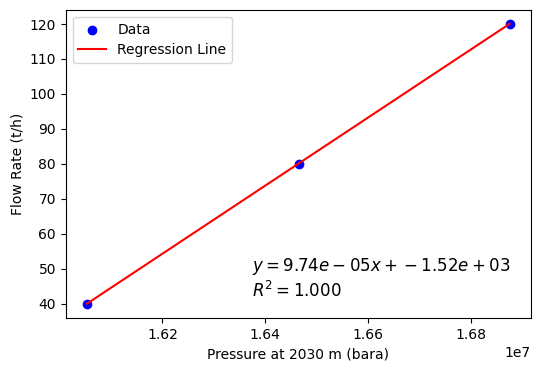

In [18]:
## Plotting the original data points
plt.figure(figsize=(6, 4))
plt.scatter(X_press_inj, Y_flowr_inj, color='blue', label='Data')
# Plotting the regression line
plt.plot(X_press_inj, Y_pred, color='red', label='Regression Line')
# Adding labels and title
plt.xlabel('Pressure at 2030 m (bara)')
plt.ylabel('Flow Rate (t/h)')
plt.legend()
# Add Text (Inside the Graph)
equation_text = f"$y = {b1:.2e}x + {b0:.2e}$\n$R^2 = {r_squared:.3f}$"
ax = plt.gca()
ax.text(0.40, 0.2, equation_text, transform=ax.transAxes, 
        fontsize=12, color="black", verticalalignment='top')
# Display the plot
plt.show()

<font size = 2>
Now, for the calculation for the fall-off test <i>(fao_ds)</i>, steps are

1. Calculate the time in hours while injection (in <i>inj_ds</i>)
2. Calculate the cumulative sum of the duration
3. Calculate (T+dt)/dt or the horner time
4. Calculate log((T+dt)/dt). This is for regression linear.
5. Define the semilog plot of the data and linear plot for the regression linear

<font>

In [11]:
# Injection duration
inject_time = inj_ds['Duration(s)'].sum()
inject_time = inject_time/3600

# Fall off cumulative duration(second)
fao_ds['c_Duration(s)'] = fao_ds['Duration(s)'].cumsum()
# Calculation of (T+dt)/dt
fao_ds['(T+dt)/dt'] = (inject_time+(fao_ds['c_Duration(s)']/3600)) / (fao_ds['c_Duration(s)']/3600)
# log 10 of the T+dt/dt
fao_ds['log(T+dt)/dt'] = np.log10(fao_ds['(T+dt)/dt'])

In [12]:
# Save file to csv
inj_ds.to_csv('inj_ds.csv', index=False)
fao_ds.to_csv('fao_ds.csv', index=False)
# Read file csv
inj_ds = pd.read_csv('inj_ds.csv')
fao_ds = pd.read_csv('fao_ds.csv')

print(inj_ds.head(5))
print(fao_ds.head(5))

                  Time  Res_Press(bar)  Mass_Flow(t/h)  Res_Press(bara)  \
0  2025-09-02 21:00:00      159.065153              40       160.065153   
1  2025-09-02 21:04:45      159.085343              40       160.085343   
2  2025-09-02 21:09:29      159.141243              40       160.141243   
3  2025-09-02 21:14:14      159.210143              40       160.210143   
4  2025-09-02 21:18:59      159.342443              40       160.342443   

   Res_Press(Pa)  Flow(kg/s)  Duration(s)  
0     16006515.3   11.111111        285.0  
1     16008534.3   11.111111        284.0  
2     16014124.3   11.111111        285.0  
3     16021014.3   11.111111        285.0  
4     16034244.3   11.111111        285.0  
                  Time  Res_Press(bar)  Mass_Flow(t/h)  Res_Press(bara)  \
0  2025-09-03 03:04:54      167.532518               0       168.532518   
1  2025-09-03 03:05:22      167.248193               0       168.248193   
2  2025-09-03 03:05:51      166.963868               0      

In [19]:
# Horner time and reservoir pressure 
X_t = fao_ds['(T+dt)/dt']
Y_press = fao_ds['Res_Press(Pa)']

# Define which range of t+dt/dt
X_horner= fao_ds[fao_ds['log(T+dt)/dt'] < 2.5]['log(T+dt)/dt']
X_horner = X_horner.to_numpy()
# Filter the data for log(T+dt)/dt less than 2.5 to get the R^2 best value
Y_press_rl = fao_ds[fao_ds['log(T+dt)/dt'] < 2.5]['Res_Press(Pa)']
Y_press_rl = Y_press_rl.to_numpy()
# Slope and intercept calculation
b1_1, b0_1, rmse_1, Y_pred_1, r_squared_1 = regression_linear(X_horner, Y_press_rl)
print(f"Slope: {b1_1} Pa/cycle, Intercept: {b0_1}")
print(f"R^2: {r_squared_1}")

Slope: 427779.9170858103 Pa/cycle, Intercept: 15623090.828876244
R^2: 0.9587023346815485


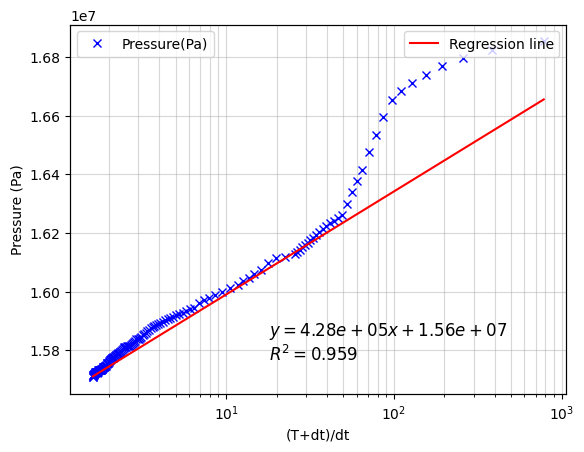

In [20]:
### Plot the semilog plot and regression line
# Create the figure and the first set of axes
fig, ax1 = plt.subplots()
ax1.semilogx(X_t, Y_press, 'x', color='blue', label='Pressure(Pa)', linestyle='none')
ax1.set_xlabel('(T+dt)/dt')
ax1.set_ylabel('Pressure (Pa)')

# Create the second set of axes that shares the same y-axis
ax2 = ax1.twiny()
ax2.plot(X_horner, Y_pred_1, color='red', label='Regression line')
ax2.set_xlabel('')
ax2.set_xticks([])  # Hide x-ticks
ax2.set_xticklabels([])  # Hide x-tick labels

# Add titles and legends
# plt.title('Two Datasets with Shared Y-axis')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, which='both', alpha=0.5)
ax2.grid(True, which='both', alpha=0.5)
# Show the plot
equation_text = f"$y = {b1_1:.2e}x + {b0_1:.2e}$\n$R^2 = {r_squared_1:.3f}$"
ax = plt.gca()
ax.text(0.40, 0.2, equation_text, transform=ax.transAxes, 
        fontsize=12, color="black", verticalalignment='top')
plt.show()

<font size = 2>
The calculation of the permeability thickness and skin factor from horner semilog plot are (Earlougher, 1977)

$$ kh=\frac{2.303 q \mu}{4 \pi m}$$

$$ s = 1.513(\frac{P_{1hr}-P_{wf}}{m} - \log{(\frac{k}{\phi \mu c_t r^2_w})} - 0.3514) $$

</font>


In [61]:
from pyXSteam.XSteam import XSteam
steam_table = XSteam(XSteam.UNIT_SYSTEM_MKS) # Use SI units

# Water injection properties
temp, m, h = 20, b1_1, 2030
mu = steam_table.my_ph(steam_table.psat_t(temp),steam_table.hL_t(temp)) #kg/m.s
q_inj_rate =  (mflowlist[-1]*(1000/3600))/(steam_table.rhoL_t(temp)) # m3/s #injection rate before fall off

# Permeability transmitivity
kh = (2.303 * q_inj_rate*mu)/(4*np.pi*m)
print(f"Transmitivity or permeability thickness is : {kh:.4e} m3 or {kh/1e-12} D.m")

# skin factor
P1hr, Pi, c_t, h, porosity, r_w, k = 160.6300*1e5, 167.532518*1e5, 1.05e-8, 2030, 0.17, 0.183, kh/h
A = (P1hr-Pi)/m
B = (k/(porosity*mu*c_t**r_w))
skin_factor = 1.1513*(A-np.log(B)-0.3514)

if skin_factor > 2:
    print(f"The skin factor is {skin_factor} which is potentially damaged due scalling")
elif skin_factor < 0:
    print(f"The skin factor is {skin_factor}, means the well is potentially stimulated")
else:
    print(f"The skin factor is {skin_factor} which is indicating no formation damage")

Transmitivity or permeability thickness is : 1.4322e-11 m3 or 14.322169303754961 D.m
The skin factor is 21.39039752755624 which is potentially damaged due scalling


<font size=2> 
The result shows that for the well with thickness of 2030 m, the permeability thickness is 14.322 D.m while the skin factor of the well is 21.39, indicating well damaged and potentially due to scalling.
However, this script only demonstrate how the analytical method using horner time and plot was done. Hence, the result of the skin factor and permeability thickness may varies with numerical method.<br>



References
- Earlougher Jr., R.C., 1977. <i>Advances in Well Test Analysis</i>. Henry L. Doherty Memorial Fund of AIME,New York.
- Zarrouk, S., McLean, K., 2019. <i>Geothermal Well Test Analysis: Fundamental, Applications and Advanced Techniques</i>. Elsevier, London.
</font>